# Plot downstream metrics

Notebook testing if RegVelo is sensitive to prior GRN structure

## Library imports

In [1]:
import pandas as pd
from scipy.stats import ttest_ind

import mplscience
import seaborn as sns
from matplotlib import pyplot as plt

import scvelo as scv

from rgv_tools import DATA_DIR, FIG_DIR
from rgv_tools.plotting._significance import add_significance, get_significance

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_t

## General settings

In [2]:
plt.rcParams["svg.fonttype"] = "none"

In [3]:
sns.reset_defaults()
sns.reset_orig()

In [4]:
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=14, color_map="viridis")

## Constants

In [5]:
DATASET = "dyngen"

In [6]:
SAVE_FIG = True
if SAVE_FIG:
    (FIG_DIR / DATASET / "processed").mkdir(parents=True, exist_ok=True)
    (FIG_DIR / DATASET / "results").mkdir(parents=True, exist_ok=True)

In [7]:
NOISE_LEVEL = [0.2, 0.4, 0.6, 0.8, 1]

## Function definations

In [8]:
def unlist(py_list):
    """Unlist a list object."""
    return [item for sublist in py_list for item in sublist]

## Data loading

In [9]:
identifiability = pd.read_parquet(DATA_DIR / DATASET / "results" / "identifiability_test.parquet")
regvelo = pd.read_parquet(DATA_DIR / DATASET / "results" / "regvelo_benchmark.parquet")
velovi = pd.read_parquet(DATA_DIR / DATASET / "results" / "velovi_benchmark.parquet")

## Visualization

### Identifiability visualization

In [10]:
grn = identifiability["grn"].tolist()
grn = [element.tolist() for element in grn]

velocity = identifiability["velocity"].tolist()
velocity = [element.tolist() for element in velocity]

time = identifiability["time"].tolist()
time = [element.tolist() for element in time]

In [11]:
n_repeat = len(grn[0])
noise_level = ["0.2"] * n_repeat + ["0.4"] * n_repeat + ["0.6"] * n_repeat + ["0.8"] * n_repeat + ["random"] * n_repeat

In [12]:
cor = unlist(grn)
df_grn = pd.DataFrame({"Noise Level": noise_level, "Correlation": cor})

cor = unlist(velocity)
df_velo = pd.DataFrame({"Noise Level": noise_level, "Correlation": cor})

cor = unlist(time)
df_time = pd.DataFrame({"Noise Level": noise_level, "Correlation": cor})

In [13]:
df_all = pd.concat([df_grn, df_velo, df_time], ignore_index=True)
df_all.loc[:, "Type"] = ["GRN"] * df_grn.shape[0] + ["Velocity"] * df_velo.shape[0] + ["Latent Time"] * df_time.shape[0]

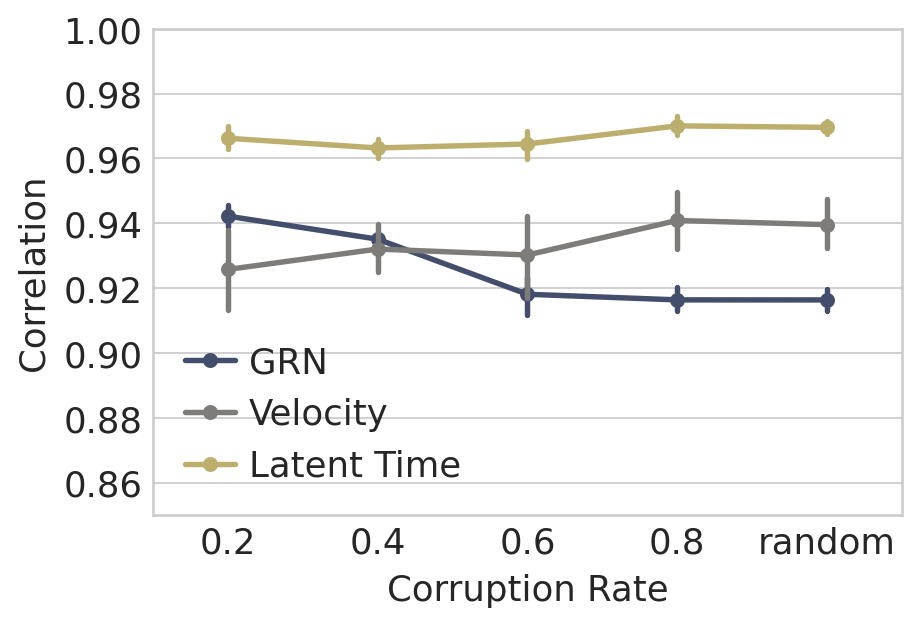

In [14]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 4))

    sns.pointplot(data=df_all, x="Noise Level", y="Correlation", hue="Type", ax=ax, palette="cividis", scale=0.8)

    plt.xlabel("Corruption Rate", fontsize=16)
    plt.ylabel("Correlation", fontsize=16)

    # Enlarge the numbers on the axes
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.legend(title="", fontsize=16)
    # y_min, y_max = ax.get_ylim()
    ax.set_ylim([0.85, 1])
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

    if SAVE_FIG:
        fig.savefig(
            FIG_DIR / DATASET / "results" / "identifiability_benchmark.svg",
            format="svg",
            transparent=True,
            bbox_inches="tight",
        )

### Inference performance visualization

#### GRN

In [15]:
noise_level = ["0.2"] * 5 + ["0.4"] * 5 + ["0.6"] * 5 + ["0.8"] * 5 + ["random"] * 5

In [16]:
grn = regvelo["grn"].tolist()
grn = [element.tolist() for element in grn]

prior_grn = regvelo["grn_prior"].tolist()
prior_grn = [element.tolist() for element in prior_grn]

In [17]:
auc_rgv = unlist(grn)
auc_prior = unlist(prior_grn)
df = pd.DataFrame(
    {"model": ["RegVelo"] * 25 + ["Prior"] * 25, "Noise Level": noise_level * 2, "AUROC": auc_rgv + auc_prior}
)

In [18]:
df.columns = ["GRN", "Noise Level", "AUROC"]

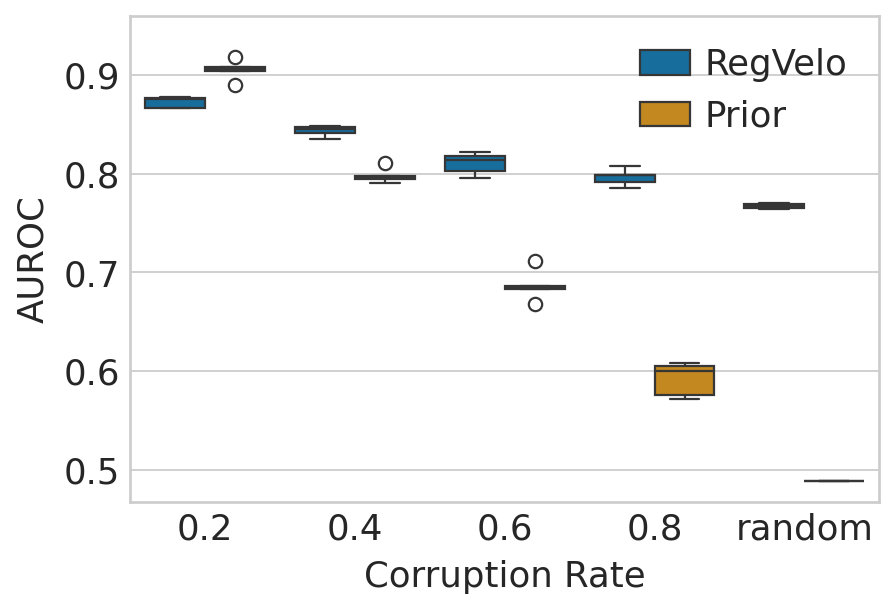

In [19]:
## compare boxplot
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 4))

    sns.boxplot(data=df, x="Noise Level", y="AUROC", hue="GRN", ax=ax, palette="colorblind")

    plt.xlabel("Corruption Rate", fontsize=16)
    plt.ylabel("AUROC", fontsize=16)

    # Enlarge the numbers on the axes
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.legend(title="", fontsize=16)
    y_min, y_max = ax.get_ylim()
    ax.set_ylim([y_min, y_max + 0.02])
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

    if SAVE_FIG:
        fig.savefig(
            FIG_DIR / DATASET / "results" / "AUROC_prior_graph.svg",
            format="svg",
            transparent=True,
            bbox_inches="tight",
        )
    plt.show()

#### velocity

In [20]:
velocity = regvelo["velocity"].tolist()
velocity = [element.tolist() for element in velocity]
velocity.append(velovi["velocity"].tolist())

df = pd.DataFrame({"Model": noise_level + ["veloVI"] * 5, "Correlation": unlist(velocity)})

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


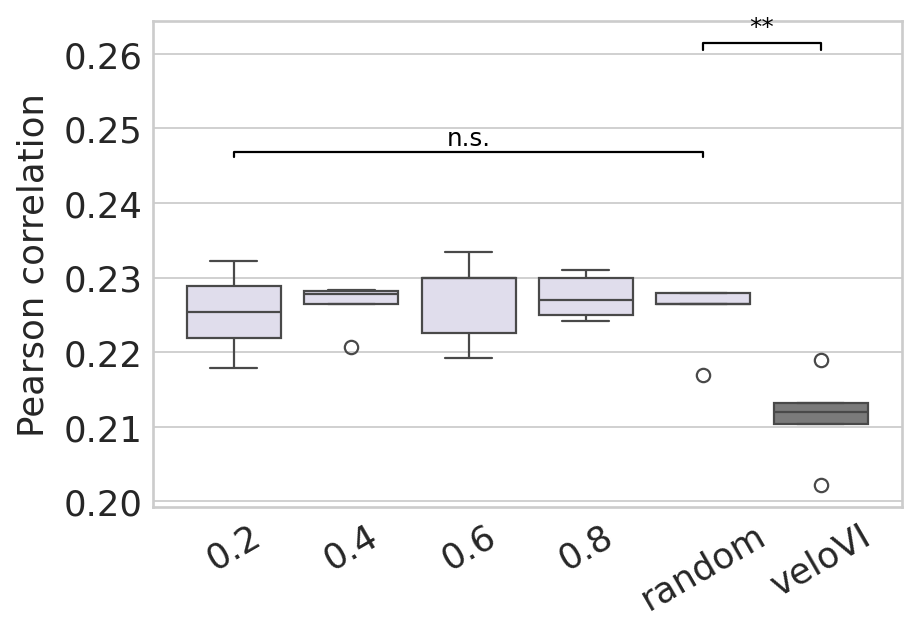

In [21]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 4))

    cool_blue = "#DEDBEE"
    warm_orange = "#7A7A7ADD"

    # Create a custom color palette
    custom_palette = [cool_blue] * 5 + [warm_orange]
    sns.boxplot(data=df, x="Model", y="Correlation", ax=ax, palette=custom_palette)

    ttest_res = ttest_ind(
        df.iloc[:, 1][df.iloc[:, 0] == "0.2"].values,
        df.iloc[:, 1][df.iloc[:, 0] == "random"].values,
        alternative="greater",
    )
    significance = get_significance(ttest_res.pvalue)
    add_significance(
        ax=ax,
        left=0,
        right=4,
        significance=significance,
        lw=1,
        bracket_level=1.05,
        c="k",
        level=0,
    )

    ttest_res = ttest_ind(
        df.iloc[:, 1][df.iloc[:, 0] == "random"].values,
        df.iloc[:, 1][df.iloc[:, 0] == "veloVI"].values,
        alternative="greater",
    )
    significance = get_significance(ttest_res.pvalue)
    add_significance(
        ax=ax,
        left=4,
        right=5,
        significance=significance,
        lw=1,
        bracket_level=1.05,
        c="k",
        level=0,
    )

    plt.xlabel("")
    plt.ylabel("Pearson correlation", fontsize=16)

    # Enlarge the numbers on the axes
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.legend(title="", fontsize=16)
    y_min, y_max = ax.get_ylim()
    ax.set_ylim([y_min, y_max])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

    if SAVE_FIG:
        fig.savefig(
            FIG_DIR / DATASET / "results" / "velocity_prediction.svg",
            format="svg",
            transparent=True,
            bbox_inches="tight",
        )
    plt.show()

#### latent time

In [22]:
time = regvelo["time"].tolist()
time = [element.tolist() for element in time]
time.append(velovi["time"].tolist())

df = pd.DataFrame({"Model": noise_level + ["veloVI"] * 5, "Correlation": unlist(time)})

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


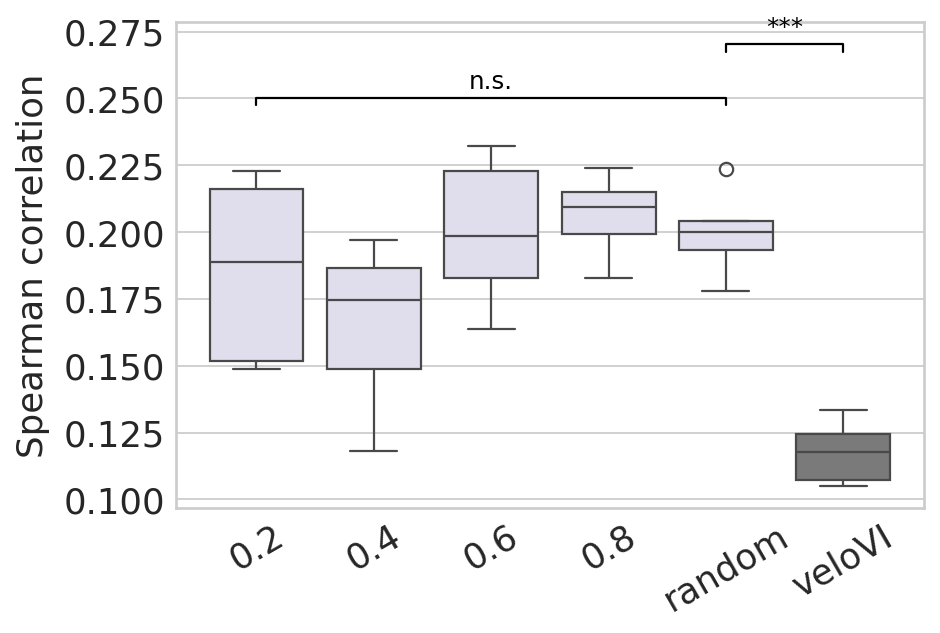

In [23]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 4))

    cool_blue = "#DEDBEE"
    warm_orange = "#7A7A7ADD"

    # Create a custom color palette
    custom_palette = [cool_blue] * 5 + [warm_orange]
    sns.boxplot(data=df, x="Model", y="Correlation", ax=ax, palette=custom_palette)

    ttest_res = ttest_ind(
        df.iloc[:, 1][df.iloc[:, 0] == "0.2"].values,
        df.iloc[:, 1][df.iloc[:, 0] == "random"].values,
        alternative="greater",
    )
    significance = get_significance(ttest_res.pvalue)
    add_significance(
        ax=ax,
        left=0,
        right=4,
        significance=significance,
        lw=1,
        bracket_level=1.05,
        c="k",
        level=0,
    )

    ttest_res = ttest_ind(
        df.iloc[:, 1][df.iloc[:, 0] == "random"].values,
        df.iloc[:, 1][df.iloc[:, 0] == "veloVI"].values,
        alternative="greater",
    )
    significance = get_significance(ttest_res.pvalue)
    add_significance(
        ax=ax,
        left=4,
        right=5,
        significance=significance,
        lw=1,
        bracket_level=1.05,
        c="k",
        level=0,
    )

    plt.xlabel("")
    plt.ylabel("Spearman correlation", fontsize=16)

    # Enlarge the numbers on the axes
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.legend(title="", fontsize=16)
    y_min, y_max = ax.get_ylim()
    ax.set_ylim([y_min, y_max])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

    if SAVE_FIG:
        fig.savefig(
            FIG_DIR / DATASET / "results" / "latent_time_prediction.svg",
            format="svg",
            transparent=True,
            bbox_inches="tight",
        )
    plt.show()